In [211]:
#import libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [212]:
#import data
data=pd.read_csv('fifa21_trainning.csv')
# target: OVA

In [213]:
#define cleaning function
def clean_df(df):
    #clean duplicates, column titles and drop some columns from inspection
    df = df.drop_duplicates('ID')
    df.columns=[e.lower().replace(' ', '_') for e in df.columns]
    df = df.drop(['goalkeeping','gk_diving','gk_handling','gk_kicking','gk_positioning','gk_reflexes','name', 'club', 'id', 'joined','contract', 'unnamed:_0', 'team_&_contract','loan_date_end','nationality', 'position', 'st', 'rw', 'cdm', 'rwb', 'rcm', 'rm', 'rs', 'ram', 'rdm', 'cb', 'rf', 'rcb', 'rb', 'cm', 'lcm', 'lm', 'cam', 'cf', 'ls', 'lf', 'lw', 'lb', 'ldm', 'lcb', 'dri'], axis=1)

    #replace NaN in numerical columns with the mean
    for col in df.select_dtypes(np.number).columns:  
        df[col].fillna(value=df[col].mean(), inplace=True)
    
    #categorical cleaning
    
    #replace NaNs with "Medium" value
    df["a/w"].fillna(value="Medium", inplace=True)
    df["d/w"].fillna(value="Medium", inplace=True)
    
    #define function to clean currency columns
    def currency(x):
                r = 0
                x = x.strip('€')
                if x.endswith('K'):
                    x.strip('€')
                    r = float(x.rstrip('K'))*1000
                elif x.endswith('M'):
                    r = float(x.rstrip('M'))*1000000
                else:
                    r = float(x)
                return r
    #apply function to relevant columns           
    df["value"]=df["value"].apply(currency)
    df["wage"]=df["wage"].apply(currency)
    df["release_clause"]=df["release_clause"].apply(currency)
    df["hits"]=df["hits"].apply(currency)
     
    #clean weight column. Remove "lbs" and convert to integer
    df['weight'] = list(map(lambda x : x.replace('lbs', '') , df['weight']))
    df['weight']  = df['weight'].astype("int64")

    #define and apply function to clean height column
    def imperial_to_metric(x):
        ft_in_lst=[int(item.strip('"')) for item in x.split("\'")]
        return ft_in_lst[0]*30.84+ft_in_lst[1]*2.54
    df['height']=df['height'].apply(imperial_to_metric)
    
    #define and apply function to columns where the data includes a star
    def clean_star(x):
        return x[0]
    df['w/f'] = list(map(clean_star, df['w/f'])) 
    df['sm'] = list(map(clean_star, df['sm'])) 
    df['ir'] = list(map(clean_star, df['ir']))   

    #return cleaned dataframe
    return df



In [214]:
#apply cleaning function to dataset and  check it
data = clean_df(data)
data.head()


,age,bp,height,weight,foot,growth,value,wage,release_clause,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,total_stats,base_stats,w/f,sm,a/w,d/w,ir,pac,sho,pas,def,phy,hits,lam,lwb,gk,ova
0,26,CM,177.06,161,Right,1,525000.0,4000.0,801000.0,258,54,47,43,70,44.0,286,61,44.0,55,63,63,346,64,73,61.0,66,82.0,306,62,73.0,71,55,45,290,54,52.0,62.0,68.0,54,54.0,148,49,56,43.0,1682,357,4,2,High,Medium,1,69,51,63,51,60,3.0,63+1,59+1,15+1,64
1,30,ST,185.04,159,Right,0,8500000.0,23000.0,0.0,365,66,79,76,68,76.0,375,83,78.0,72,63,79,404,83,83,88.0,75,75.0,372,74,81.0,75,74,68,313,54,33.0,78.0,72.0,76,70.0,77,35,20,22.0,1961,412,3,4,High,Low,2,83,75,68,33,71,44.0,76+1,57+2,18+2,77
2,33,CAM,164.36,134,Right,0,9000000.0,49000.0,15300000.0,336,73,76,34,78,75.0,424,85,89.0,91,74,85,424,84,76,93.0,78,93.0,308,79,34.0,75,42,78,332,75,26.0,80.0,78.0,73,82.0,80,23,29,28.0,1925,404,4,4,High,Medium,2,80,77,78,27,56,73.0,80+0,59+2,12+2,80
3,22,CDM,179.60,152,Right,13,275000.0,4000.0,694000.0,242,44,42,58,62,36.0,259,54,41.0,46,57,61,282,54,59,59.0,55,55.0,277,57,60.0,64,58,38,257,61,57.0,31.0,54.0,54,48.0,168,55,58,55.0,1527,329,2,2,Medium,Medium,1,57,44,54,57,60,7.0,53+2,56+2,14+2,59
4,23,CDM,182.14,150,Right,8,725000.0,2000.0,1400000.0,249,49,37,61,68,34.0,280,64,44.0,45,61,66,324,66,66,61.0,62,69.0,280,61,34.0,81,61,43,294,66,60.0,55.0,64.0,49,58.0,185,58,61,66.0,1664,360,2,3,Low,Medium,1,66,44,60,60,66,4.0,61+2,64+2,15+2,65


In [215]:
#Columns to drop after inspecting heatmap below
data=data.drop(['lwb','wage','strength','pas','def','lam','total_stats','release_clause','positioning','growth','gk',"interceptions", "marking", "standing_tackle", "sliding_tackle", "mentality","power", "long_shots", "penalties","dribbling","ball_control","skill", "volleys","attacking", "movement", "acceleration","short_passing", "curve"], axis=1)


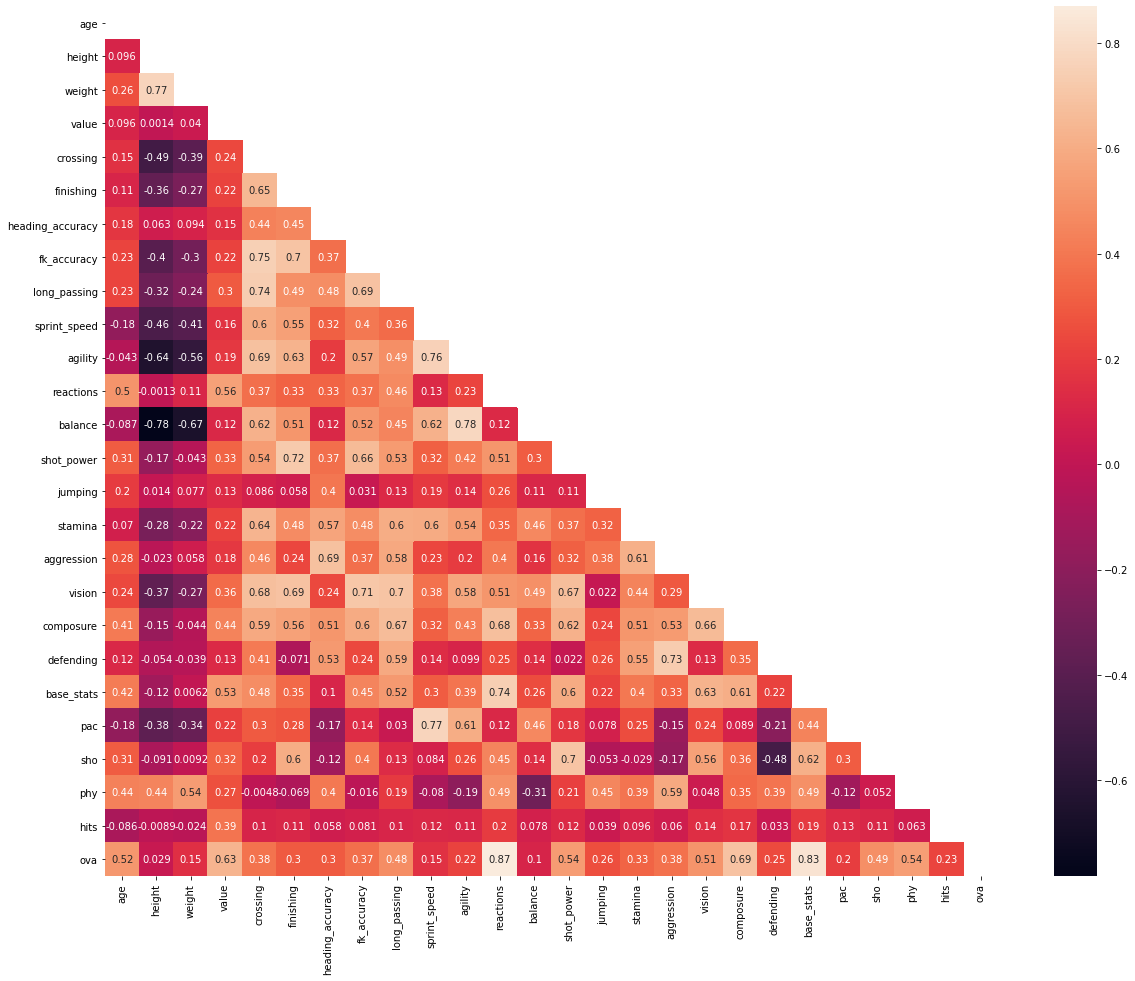

In [216]:
#create heatmap to show multicollinearity between numerical values

numericals =data._get_numeric_data()
corr_matrix=numericals.corr(method='pearson')  
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20, 16))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.show()

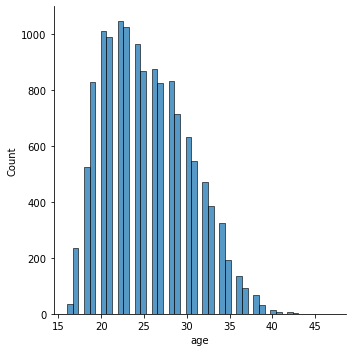

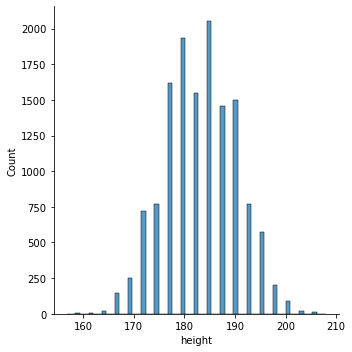

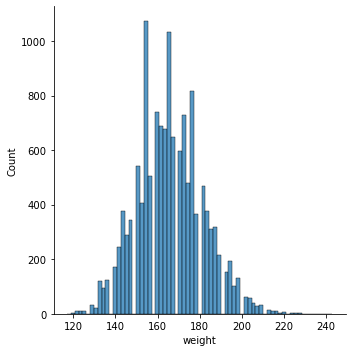

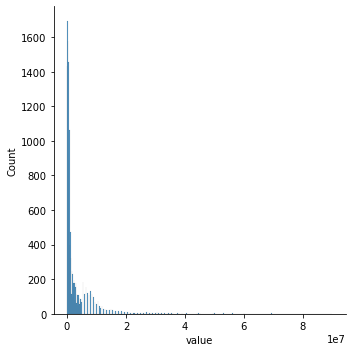

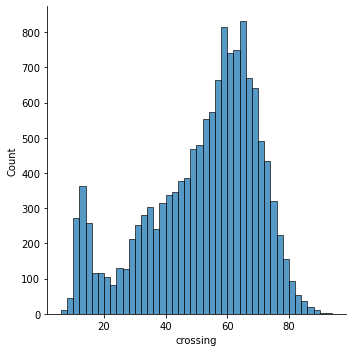

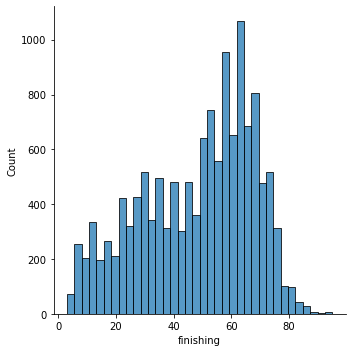

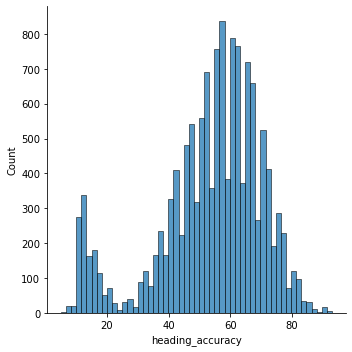

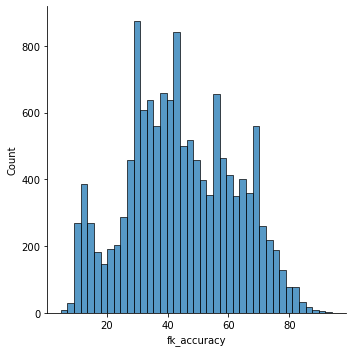

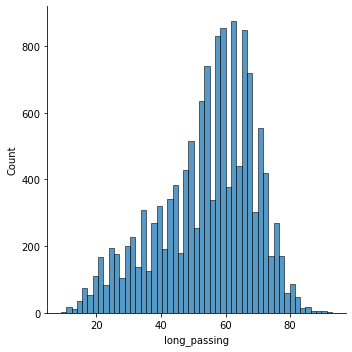

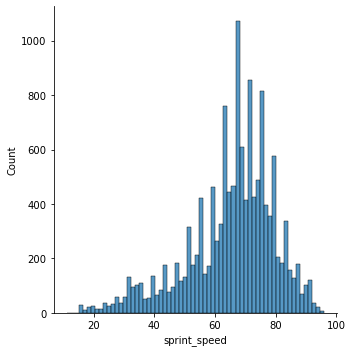

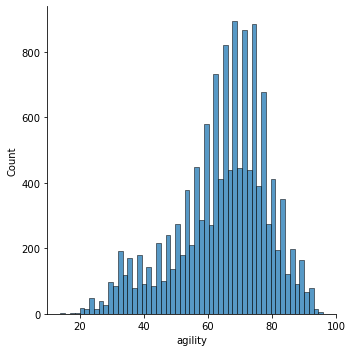

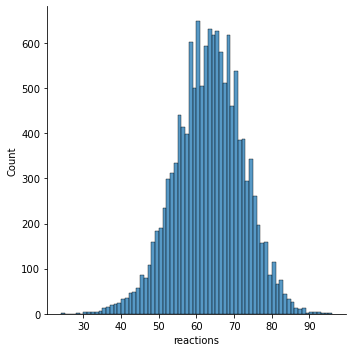

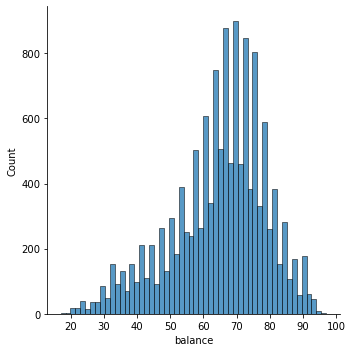

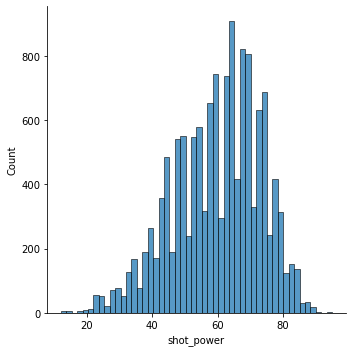

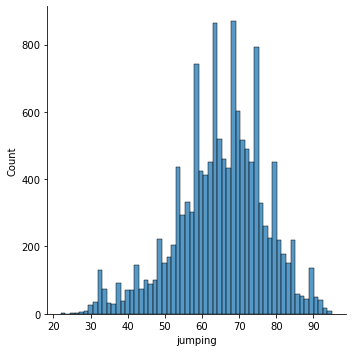

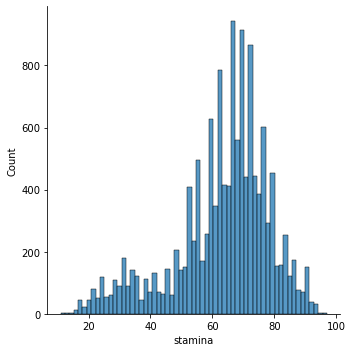

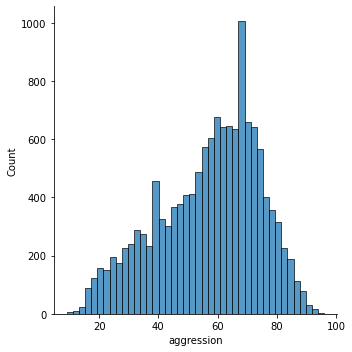

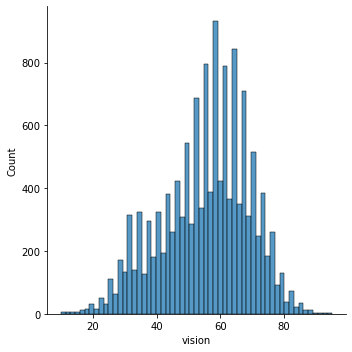

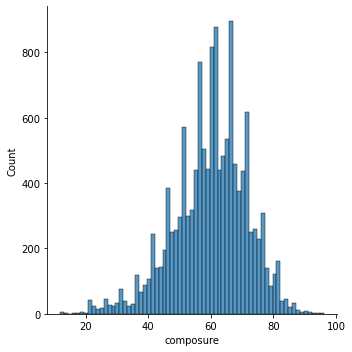

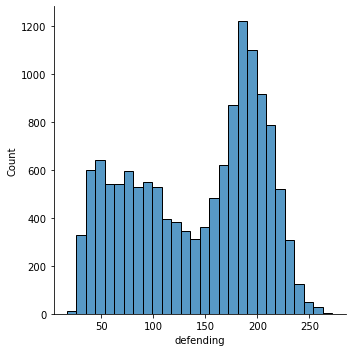

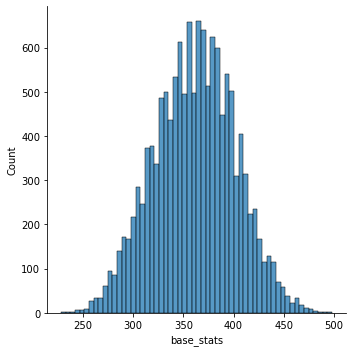

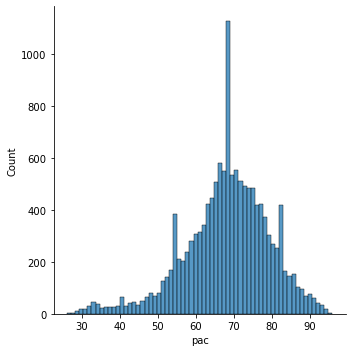

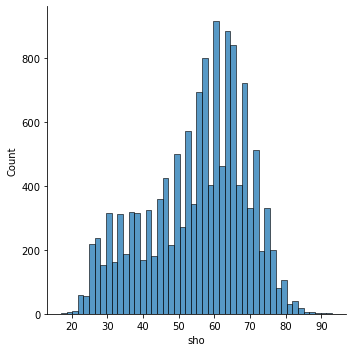

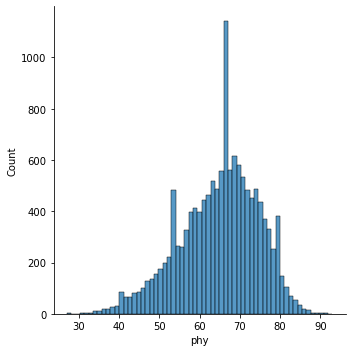

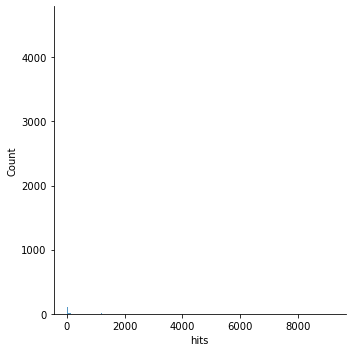

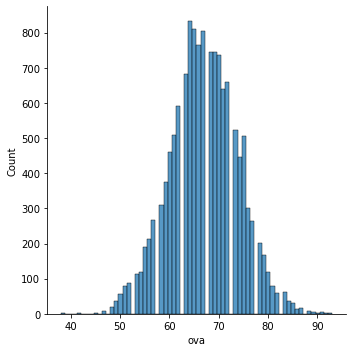

In [217]:
#check numerical columns for their distributions

for x in numericals:
    sns.displot(numericals[x])
plt.show()

In [218]:
#apply transformations to relevant columns (checked separately)


s_p_b, lmbda = stats.boxcox(data['shot_power'])
data['shot_power_transformed'] = s_p_b
data = data.drop(["shot_power"], axis=1)
jump_b, lmbda = stats.boxcox(data['jumping'])
data['jumping_transformed'] = jump_b
data = data.drop(["jumping"], axis=1)
stam_b, lmbda = stats.boxcox(data['stamina'])
data['stamina_transformed'] = stam_b
data = data.drop(["stamina"], axis=1)
aggr_b, lmbda = stats.boxcox(data['aggression'])
data['aggression_transformed'] = aggr_b
data = data.drop(["aggression"], axis=1)
vis_b, lmbda = stats.boxcox(data['vision'])
data['vision_transformed'] = vis_b
data = data.drop(["vision"], axis=1)
comp_b, lmbda = stats.boxcox(data['composure'])
data['composure_transformed'] = comp_b
data = data.drop(["composure"], axis=1)
pac_b, lmbda = stats.boxcox(data['pac'])
data['pac_transformed'] = pac_b
data = data.drop(["pac"], axis=1)
sho_b, lmbda = stats.boxcox(data['sho'])
data['sho_transformed'] = sho_b
data = data.drop(["sho"], axis=1)
hacc_b, lmbda = stats.boxcox(data['heading_accuracy'])
data['heading_accuracy_transformed'] = hacc_b
data = data.drop(["heading_accuracy"], axis=1)
fkac_b, lmbda = stats.boxcox(data['fk_accuracy'])
data['fk_accuracy_transformed'] = fkac_b
data = data.drop(["fk_accuracy"], axis=1)
lpas_b, lmbda = stats.boxcox(data['long_passing'])
data['long_passing_transformed'] = lpas_b
data = data.drop(["long_passing"], axis=1)
sspe_b, lmbda = stats.boxcox(data['sprint_speed'])
data['sprint_speed_transformed'] = sspe_b
data = data.drop(["sprint_speed"], axis=1)
agi_b, lmbda = stats.boxcox(data['agility'])
data['agility_transformed'] = agi_b
data = data.drop(["agility"], axis=1)
bal_b, lmbda = stats.boxcox(data['balance'])
data['balance_transformed'] = bal_b
data = data.drop(["balance"], axis=1)
hits_bc, lmbda = stats.boxcox(data['hits'])
data['hits_transformed']= hits_bc
data = data.drop(["hits"], axis=1)
age_bc, lmbda = stats.boxcox(data['age'])
data['age_transformed']= age_bc
data = data.drop(["age"], axis=1)
wei_bc, lmbda = stats.boxcox(data['weight'])
data['weight_transformed']= wei_bc
data = data.drop(["weight"], axis=1)
def_bc, lmbda = stats.boxcox(data['defending'])
data['defending_transformed']= def_bc
data = data.drop(["defending"], axis=1)
cro_bc, lmbda = stats.boxcox(data['crossing'])
data['crossing_transformed']= cro_bc
data = data.drop(["crossing"], axis=1)
fin_bc, lmbda = stats.boxcox(data['finishing'])
data['finishing_transformed']= fin_bc
data = data.drop(["finishing"], axis=1)



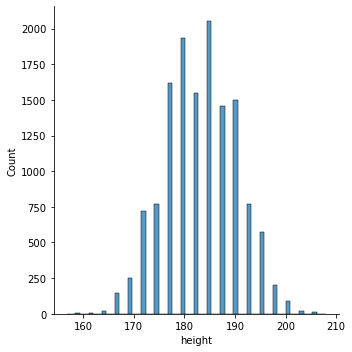

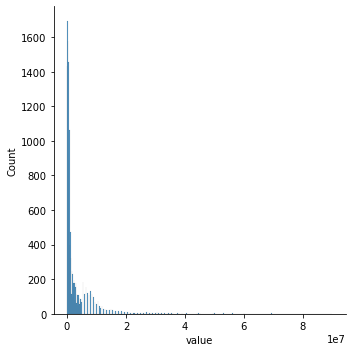

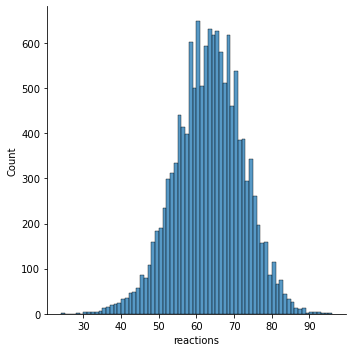

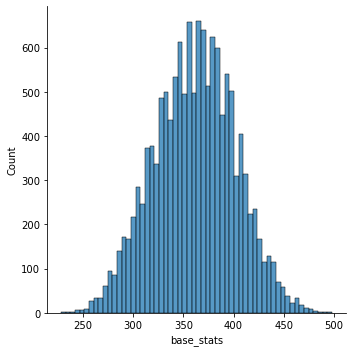

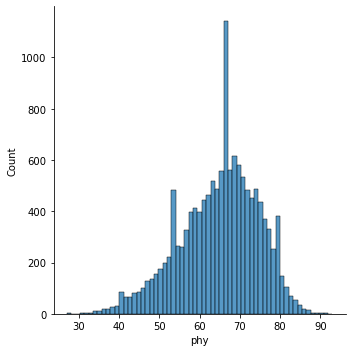

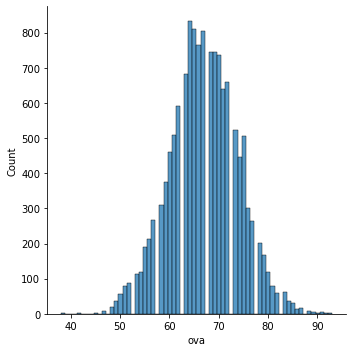

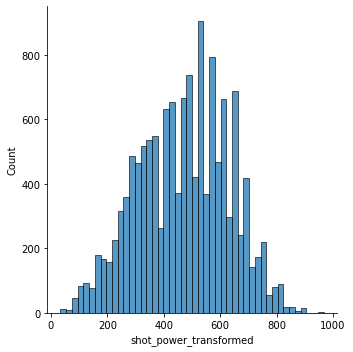

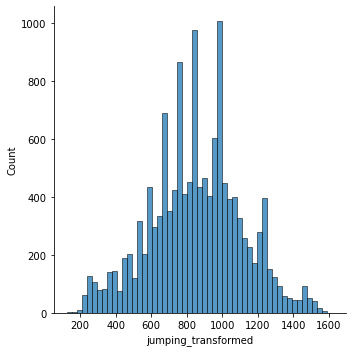

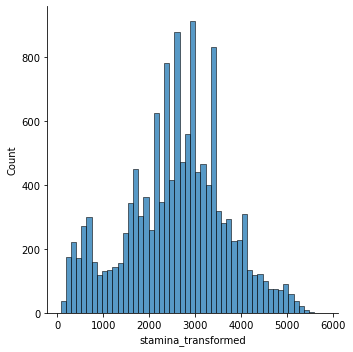

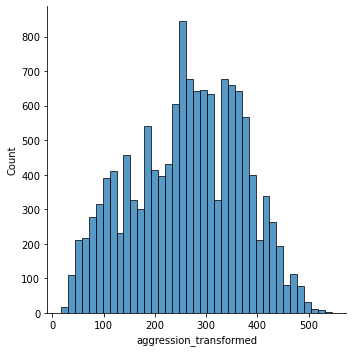

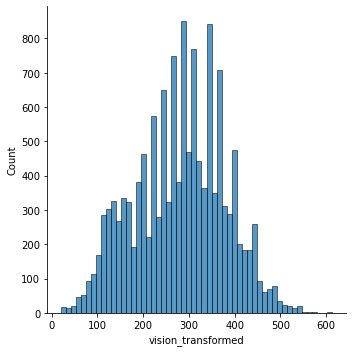

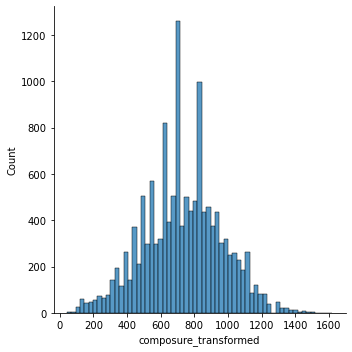

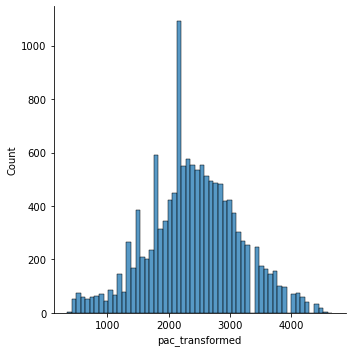

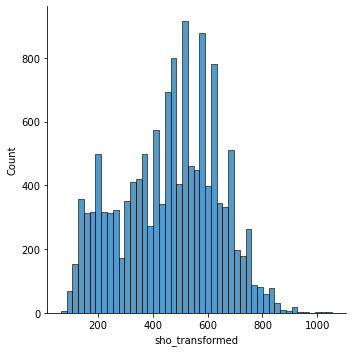

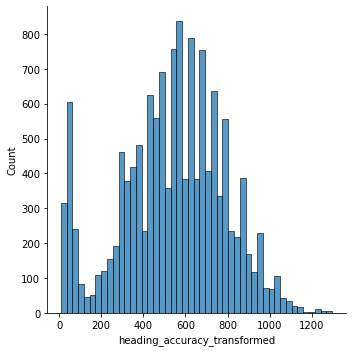

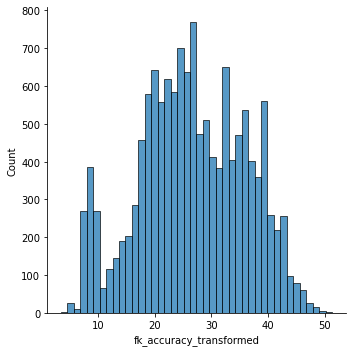

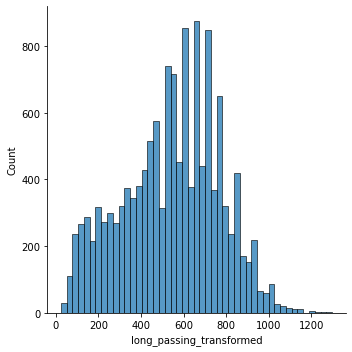

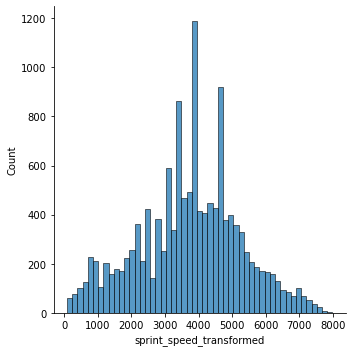

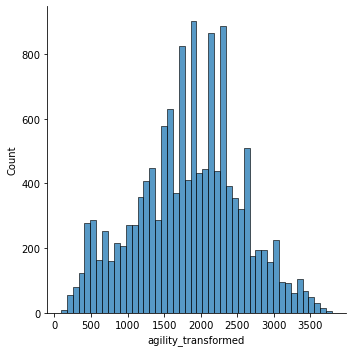

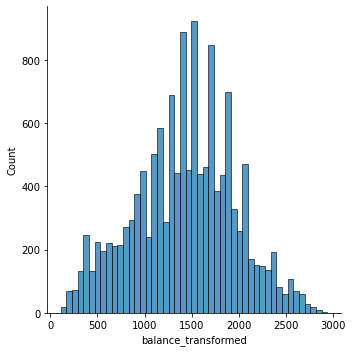

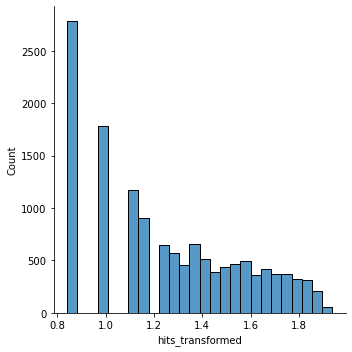

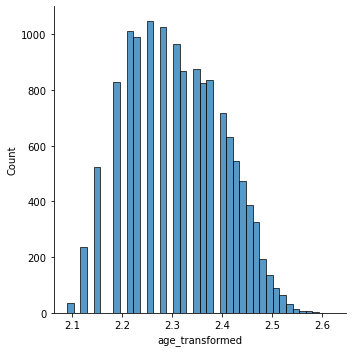

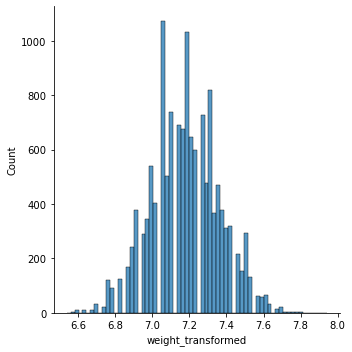

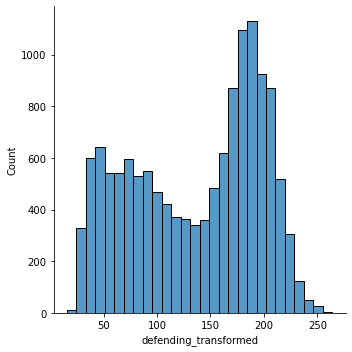

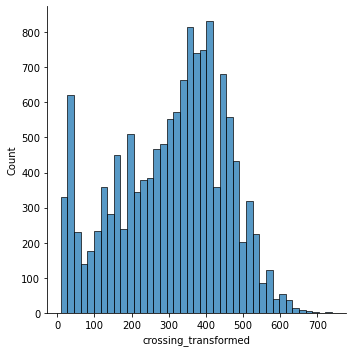

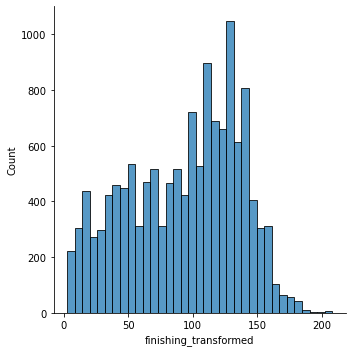

In [219]:
#show plots after transformations
numericals =data._get_numeric_data()
for x in numericals:
    sns.displot(numericals[x])
plt.show()

In [220]:
#replace Low, Medium and High values with 1, 2 and 3
def clean_w(x):
    if x.startswith('L'):
        return 1
    elif x.startswith('M'):
        return 2
    else:
        return 3
data['a/w'] = list(map(clean_w, data['a/w']))
data['d/w'] = list(map(clean_w, data['d/w'])) 

In [221]:
data.head()

,bp,height,foot,value,reactions,base_stats,w/f,sm,a/w,d/w,ir,phy,ova,shot_power_transformed,jumping_transformed,stamina_transformed,aggression_transformed,vision_transformed,composure_transformed,pac_transformed,sho_transformed,heading_accuracy_transformed,fk_accuracy_transformed,long_passing_transformed,sprint_speed_transformed,agility_transformed,balance_transformed,hits_transformed,age_transformed,weight_transformed,defending_transformed,crossing_transformed,finishing_transformed
0,CM,177.06,Right,525000.0,66,357,4,2,3,2,1,60,64,484.730689,1022.547211,3065.993703,234.611499,371.062397,594.673766,2412.014505,391.786796,349.217690,32.445938,669.290229,4451.468321,1565.397176,2141.202522,0.840516,2.344208,7.135054,143.663632,312.666756,87.997943
1,ST,185.04,Right,8500000.0,75,412,3,4,3,1,2,71,77,645.224082,1226.134132,3431.015639,234.611499,404.303122,934.552610,3492.630969,739.601201,919.531123,40.889524,669.290229,5855.221807,3201.785837,1809.768696,1.673119,2.414265,7.111263,74.542207,427.041250,166.204197
2,CAM,164.36,Right,9000000.0,78,404,4,4,3,2,2,56,80,717.136483,269.084793,3431.015639,380.004865,455.906922,1231.046392,3244.251760,772.363256,234.179516,49.936047,879.854086,4851.177416,3566.582419,2714.464896,1.737528,2.459746,6.789437,77.468540,499.407604,158.522512
3,CDM,179.60,Right,275000.0,55,329,2,2,2,2,1,60,59,423.113381,726.018644,2477.724819,280.600545,262.488615,484.336809,1644.722862,307.149390,580.860772,27.801187,564.573555,2825.306121,1466.735017,1008.630631,1.232574,2.259657,7.025881,163.094976,227.415912,76.642719
4,CDM,182.14,Right,725000.0,62,360,2,3,1,2,1,66,65,472.153386,269.084793,4018.074446,315.003378,338.782504,673.512842,2206.440286,307.149390,632.848383,27.276080,633.573259,3589.474199,1565.397176,1546.581879,0.993051,2.282452,7.000856,179.601174,268.842374,65.576543


In [222]:
#scale numerical columns using Standard Scaler

num_cols = data.select_dtypes(np.number).columns
for c in num_cols[:-1]:   # we'll normalize all less the target column
    data[c]=StandardScaler().fit_transform(data[c].values.reshape(-1, 1))

In [223]:
#Convert categorical columns to numerical values using one hot data
cat_cols= data.select_dtypes(np.object).columns
one_hot_data=pd.get_dummies(data[cat_cols], drop_first=True)
data=pd.concat([data, one_hot_data], axis=1)   # concat dataframes
data.drop(columns=cat_cols, inplace=True)
data.head()

,height,value,reactions,base_stats,a/w,d/w,phy,ova,shot_power_transformed,jumping_transformed,stamina_transformed,aggression_transformed,vision_transformed,composure_transformed,pac_transformed,sho_transformed,heading_accuracy_transformed,fk_accuracy_transformed,long_passing_transformed,sprint_speed_transformed,agility_transformed,balance_transformed,hits_transformed,age_transformed,weight_transformed,defending_transformed,crossing_transformed,finishing_transformed,bp_CB,bp_CDM,bp_CF,bp_CM,bp_GK,bp_LB,bp_LM,bp_LW,bp_LWB,bp_RB,bp_RM,bp_RW,bp_RWB,bp_ST,foot_Right,w/f_2,w/f_3,w/f_4,w/f_5,sm_2,sm_3,sm_4,sm_5,ir_2,ir_3,ir_4,ir_5
0,-0.872133,-0.382406,0.342515,-0.107236,1.391755,-0.125541,-0.499170,-0.429437,0.102007,0.643482,0.454282,-0.252670,0.929597,-0.584132,-0.002256,-0.384104,-0.766316,0.621767,0.558163,0.474873,-0.371220,1.348741,-1.297971,0.260679,-0.256019,0.116947,0.037978,87.997943,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
1,0.261106,1.123916,1.340814,1.258988,1.391755,-2.034432,0.630587,1.465624,1.099356,1.425444,0.788382,-0.252670,1.267632,0.879411,1.454418,1.582875,1.555101,1.522756,0.558163,1.399272,1.914041,0.725709,1.330289,0.981445,-0.386564,-1.036643,0.827245,166.204197,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0
2,-2.675660,1.218356,1.673580,1.060264,1.391755,-0.125541,-0.909990,1.902945,1.546239,-2.250510,0.788382,1.102237,1.792408,2.156134,1.119603,1.768153,-1.234570,2.488082,1.482591,0.738089,2.423489,2.426364,1.533608,1.449371,-2.152433,-0.987804,1.326625,158.522512,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
3,-0.511428,-0.429626,-0.877629,-0.802768,-0.470443,-0.125541,-0.499170,-1.158307,-0.280899,-0.495462,-0.084154,0.175898,-0.174525,-1.059251,-1.036567,-0.862750,0.176569,0.126140,0.098430,-0.595987,-0.509004,-0.780277,-0.060370,-0.609210,-0.855057,0.441243,-0.550314,76.642719,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0
4,-0.150723,-0.344630,-0.101174,-0.032715,-2.332640,-0.125541,0.117061,-0.283663,0.023849,-2.250510,1.325710,0.496494,0.601332,-0.244645,-0.279370,-0.862750,0.388181,0.070108,0.401356,-0.092767,-0.371220,0.230968,-0.816468,-0.374687,-0.992371,0.716720,-0.264442,65.576543,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0


In [224]:
#define y (dependent variable) and x (independent variables)
y=data['ova']
X=data.drop(columns=['ova'])



In [233]:
#split data into training and testing
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=100)

In [234]:
#apply linear regression
lm=LinearRegression()    # model
lm.fit(X_train, y_train)   # model train
predictions=lm.predict(X_test)   # model prediction

In [235]:
#calculate R squared value
r2 = r2_score(y_test, predictions)
r2

0.90992284278987

In [236]:
#Calculate root mean squared value
rmse = mean_squared_error(y_test, predictions)**0.5
print(rmse)

0.29773075774076835


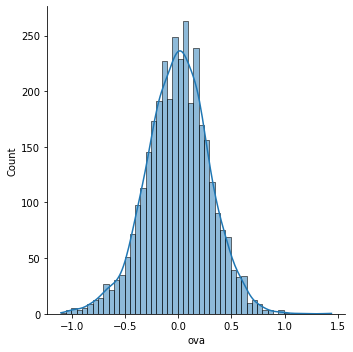

In [237]:
#plot of test data against predictions
sns.displot(y_test-predictions, kde=True)
plt.show()


Further ideas: 

Separate goalkeeper data into separate model. 

Deal with outliers in value column.

Test a wider variety of transformations for the numerical columns.

Test different options for categorical columns - e.g. High/Medium/Low to 3/2/1 

